In [1]:
import cv2
import numpy as np, matplotlib.pyplot as plt
from cvflow import *
import laneFindingPipeline, utils
%matplotlib inline

In [2]:
from utils import show

In [3]:
allFrames = laneFindingPipeline.utils.loadFrames()#maxframes=100)

HBox(children=(IntProgress(value=0, description='load project: ', max=1260), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load challenge: ', max=484), HTML(value='')))

HBox(children=(IntProgress(value=0, description='load harder_challenge: ', max=1199), HTML(value='')))

In [4]:
class HSVshow(Pipeline):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        undistort = Undistort(self.input)
        perspective = Perspective(undistort)
        hsv = CvtColor(perspective, cv2.COLOR_RGB2HSV)
        s, v = [ColorSplit(hsv, k) for k in range(1, 3)]
#         s_binary = CountSeekingThreshold(s, goalCount=11000)
#         v_binary = CountSeekingThreshold(v, goalCount=11000)
        s_sharp = UnsharpMask(Blur(s))
        s_binary = SobelClip(
            s_sharp, narrowIterations=5, wideIterations=16, dilationIterations=8,
            thresholdKwargs=dict(
                goalCount=13000,
            )
        )
        s_binary.nodeName = 'SobelClip(Unsharp))'
        
        # Do some DilateSobels directly on HS[V].
        self.vdilateSobel = DilateSobel(v, dilationIterations=10, sx_thresh=30)
        self.vdilateSobelInv = DilateSobel(self.vdilateSobel, dilationIterations=10, sx_thresh=30)
        trenchesNridges = self.vdilateSobel | self.vdilateSobelInv
        trenchesNridges.nodeName = 'trenches and ridges'
        
        resobel = DilateSobel(trenchesNridges, preblurksize=65)
        #resobel = Blur(trenchesNridges, ksize=65)
        resobel.nodeName = 'resobel'
        self.includeInMultistep([resobel])
        
        whiteTarget = resobel & trenchesNridges
        whiteTarget.nodeName = 'targeting white lines'
        self.includeInMultistep([whiteTarget])
        
        # Do a SobelClip on HS[V].
        v_binary = SobelClip(
            v, narrowIterations=10, wideIterations=20, dilationIterations=8,
            thresholdKwargs=dict(
                goalCount=19000,
            )
        )
        v_binary.nodeName = 'SobelClip(HS[V])'
        
        self.output = s_binary & trenchesNridges | whiteTarget | v_binary
        self.constructColorOutpout(self.vdilateSobel, self.vdilateSobelInv, s_binary)
        
        self.includeInMultistep([
            undistort, perspective, hsv, s, v, #h,
            self.vdilateSobel, self.vdilateSobelInv,
            s_sharp,
            s_binary, v_binary,
            self.output.nparent(1),
            self.output.nparent(2),
            self.output.nparent(3),
            self.output.nparent(4),
        ])

HBox(children=(IntProgress(value=0, description='cal. undistort: ', max=20), HTML(value='')))


Saved to /tmp/HSVshow.png.
Saved to /tmp/HSVshow0.png.
Saved to /tmp/HSVshow1.png.
Saved to /tmp/HSVshow2.png.
Saved to /tmp/HSVshow3.png.
Saved to /tmp/HSVshow4.png.
Saved to /tmp/HSVshow5.png.
Saved to /tmp/HSVshow6.png.
Saved to /tmp/HSVshow7.png.


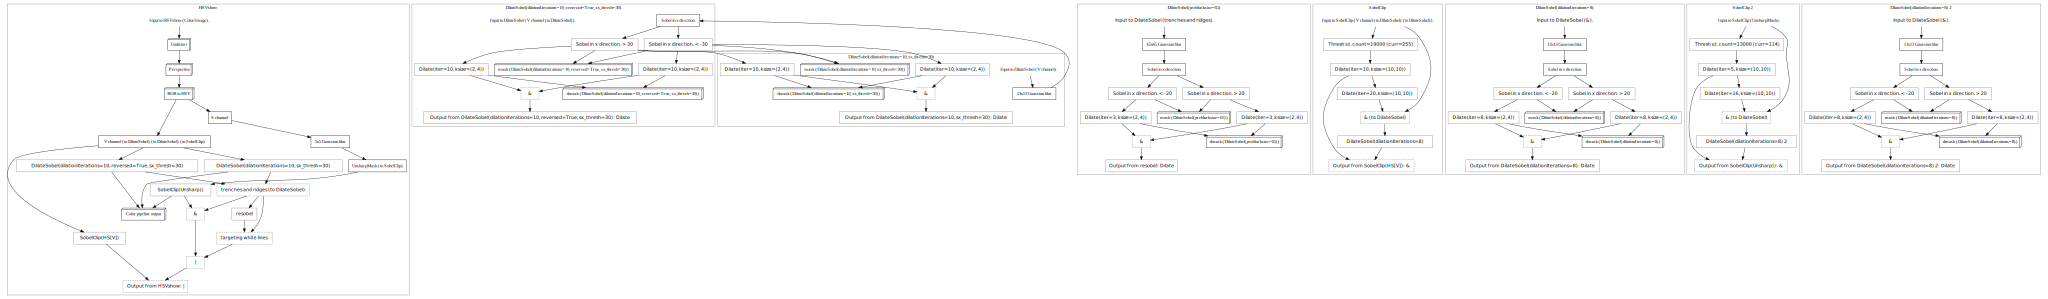

In [5]:
frame = allFrames['harder_challenge'][-12]
hsvshow = HSVshow()
hsvshow(frame)
hsvshow.assembleGraph()
hsvshow.draw(addKey=False, savePath='/tmp/%s' % hsvshow, format='png')

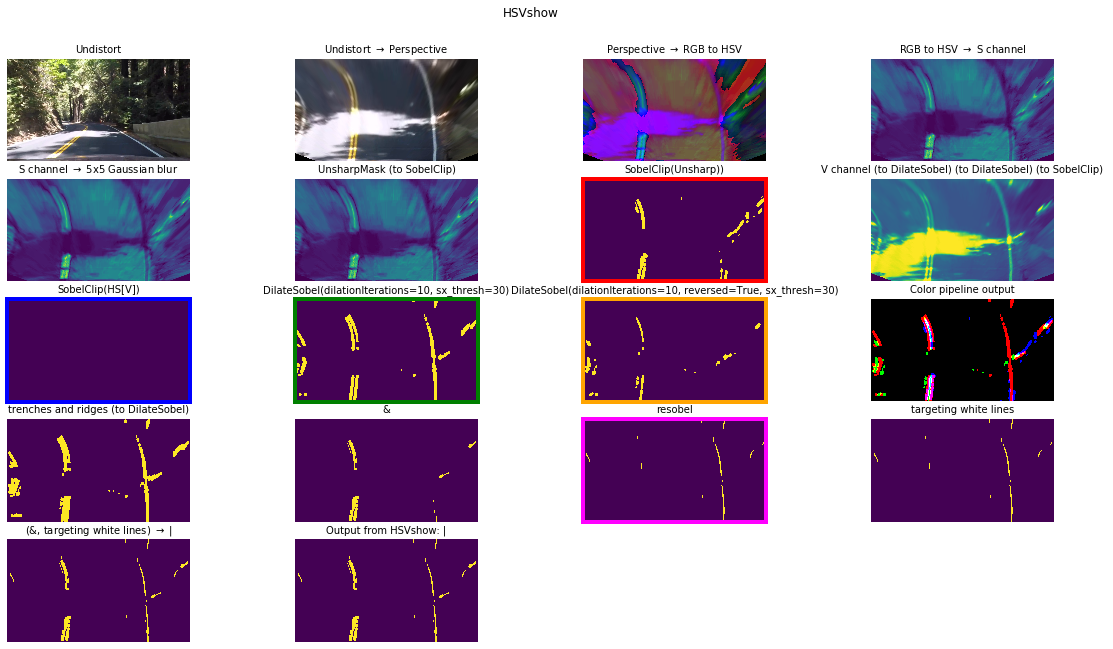

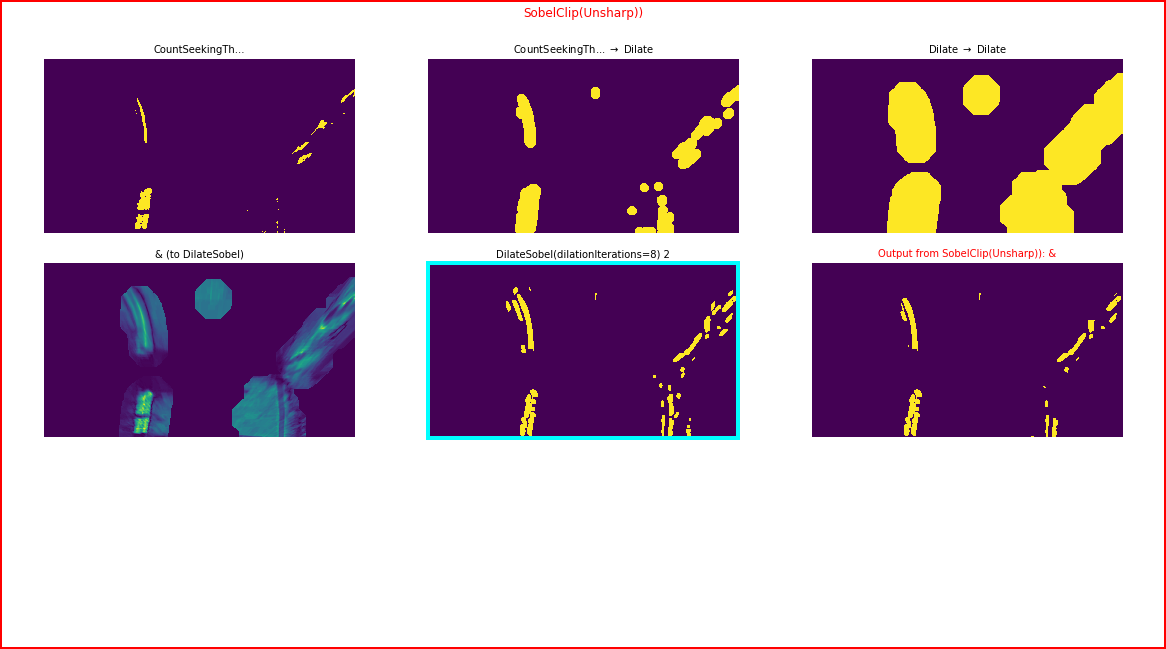

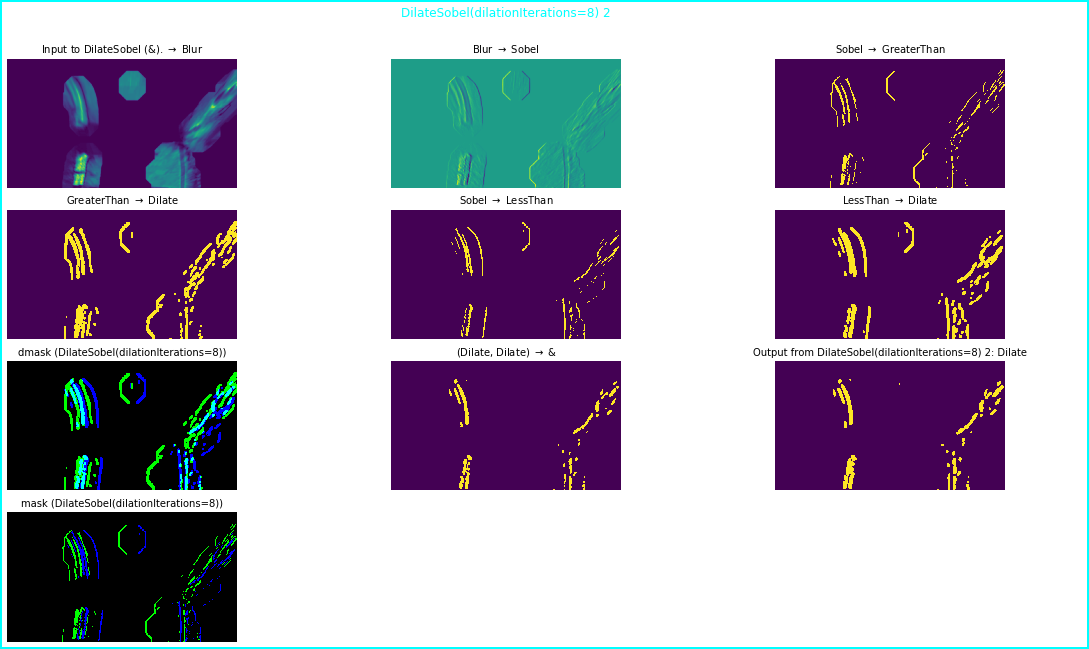

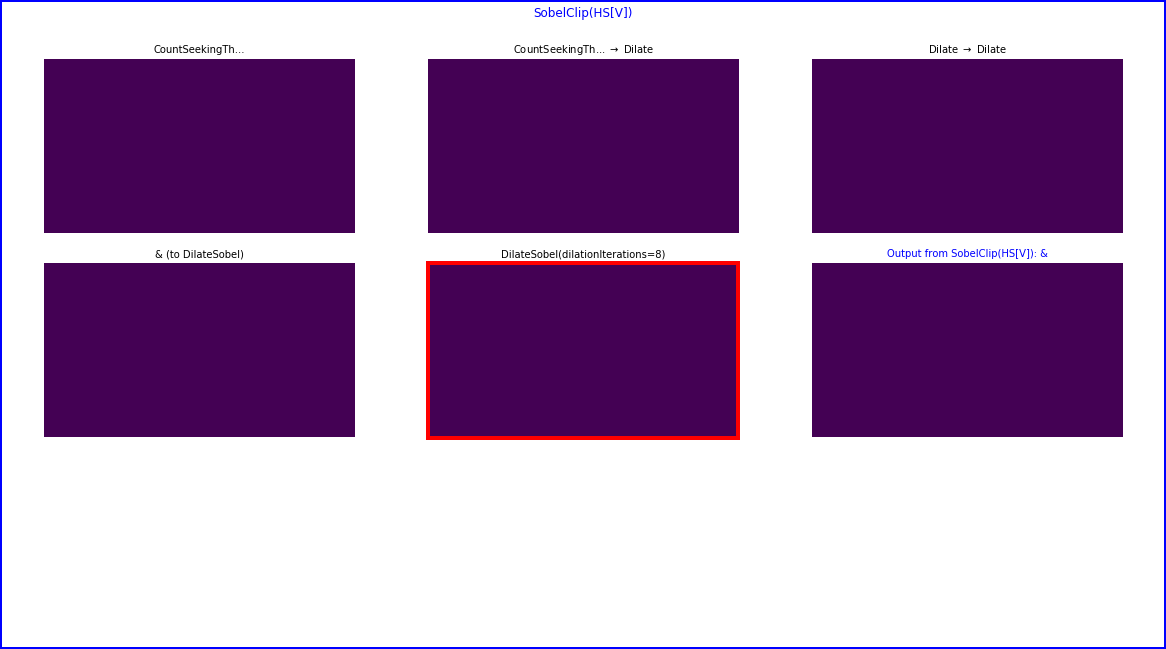

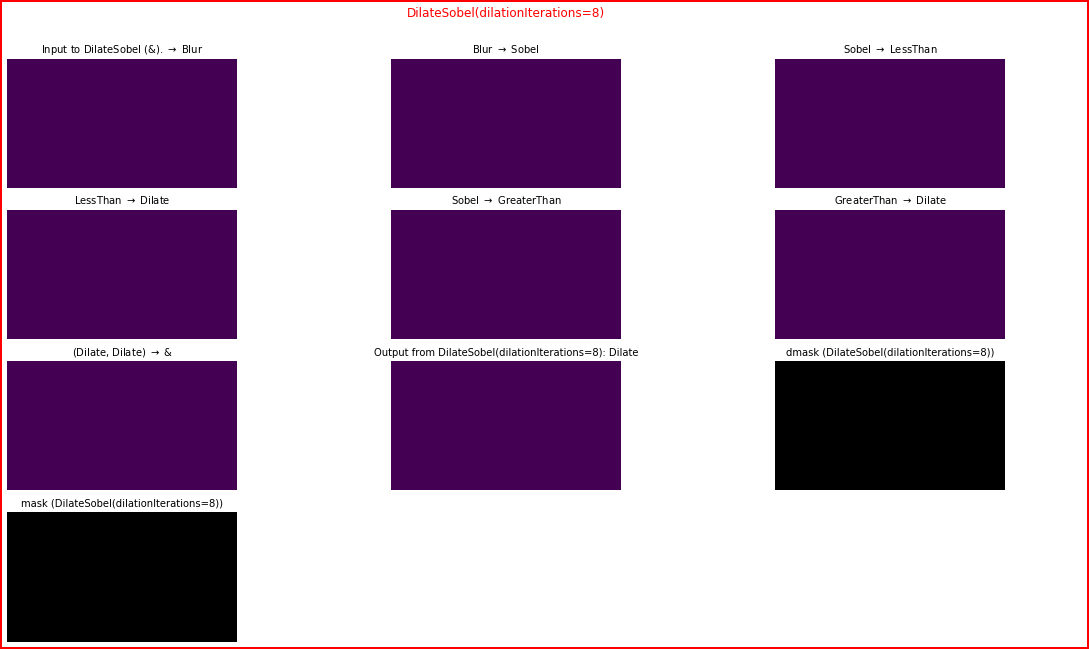

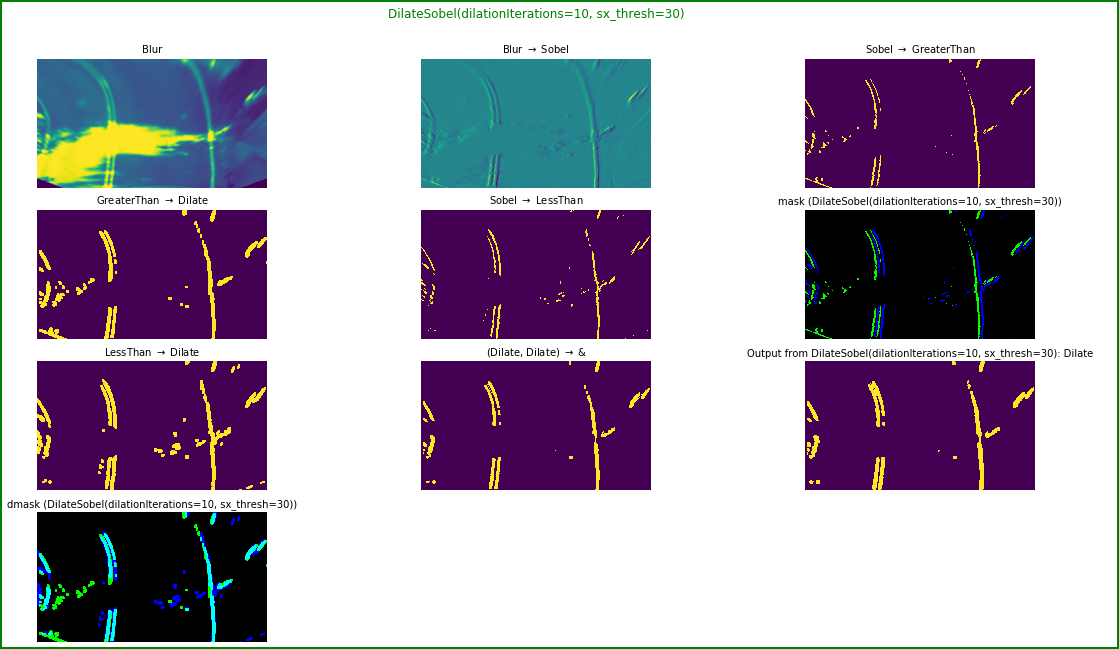

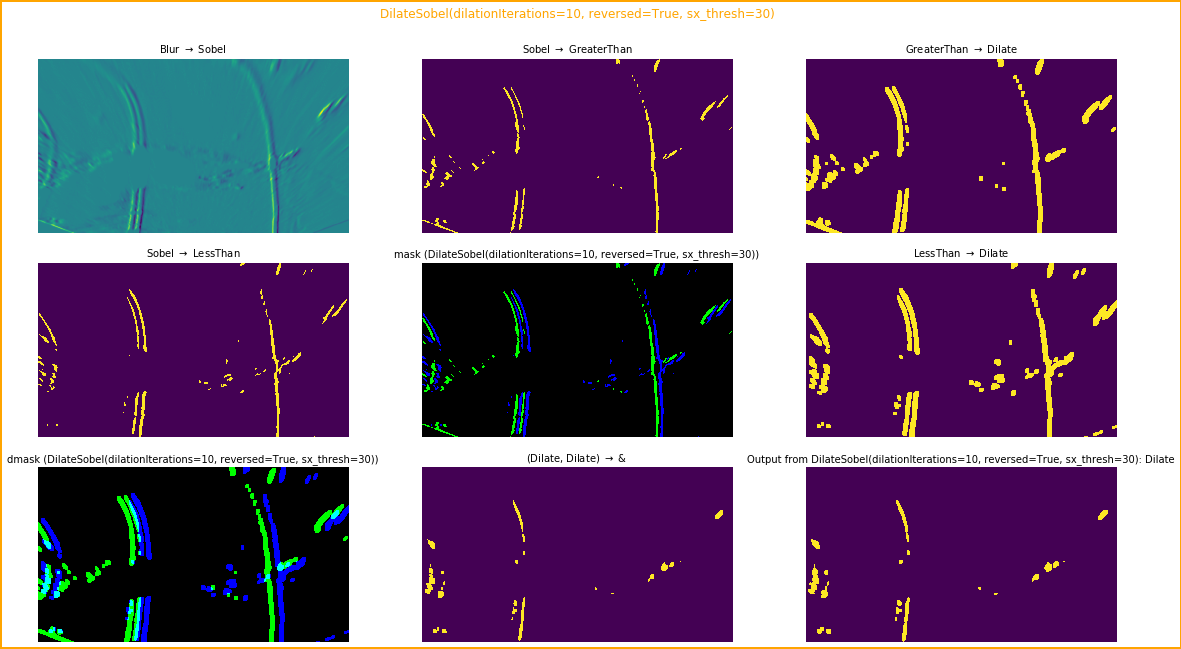

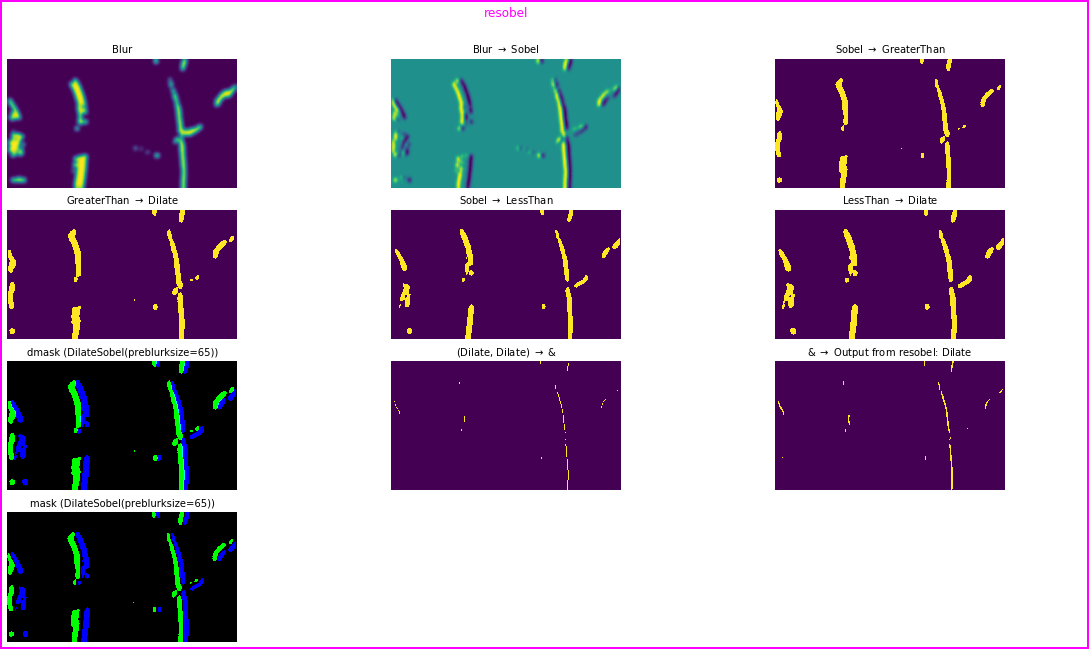

In [6]:
hsvshow.showMembers(
    subplotKwargs=dict(figsize=(16,9)), 
    wspace=0, showMultistepParents=True,
)

In [7]:
import cvflow as cf
class VisualizeFilter:
    def __init__(self, colorFilter):
        self.colorFilter = colorFilter
    
    
    def __call__(self, frame, clearAxes=True, closeFigure=False, **kwargs):
        self.colorFilter(frame)
        axes = getattr(self, 'axes', None)
        fig = self.colorFilter.showMembers(
            axes=axes, subplotKwargs=dict(figsize=(16,9)), 
            wspace=0, showMultistepParents=False, **kwargs
        )[0]
        self.axes = fig.axes
        for ax in fig.axes:
            cf.misc.clearTicks(ax)
        out = utils.fig2img(fig)
        if clearAxes:
            for ax in fig.axes:
                ax.cla()
        if closeFigure:
            plt.close(fig)
        return out
    
    @property
    def fig(self):
        return self.axes[0].figure
    
    def visualizeFromKey(self, k, maxFrames=np.inf, **kwargs):
        frames = allFrames[k]
        fpath = 'cf-%s-%s-vis' % (self.colorFilter, k)
        if maxFrames < np.inf:
            frames = frames[:maxFrames]
            fpath += '-%dframes' % maxFrames
        fpath += '.mp4'
        vid = utils.transformVideo(frames, fpath, lambda frame: self(frame, **kwargs), desc=fpath)
        self(frames[-1], clearAxes=False)
        return vid, self.fig
        
    def __del__(self):
        if hasattr(self, 'axes'):
            plt.close(self.fig)

In [8]:
# visualizeFilter = VisualizeFilter(hsvshow)
# vid, fig = visualizeFilter.visualizeFromKey('harder_challenge', maxFrames=32)
# fig

In [9]:
# vid

In [40]:
class NegPosDilateSobelS(Pipeline):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        undistort = Undistort(self.input)
        perspective = Perspective(undistort)
        
        hsv = CvtColor(perspective, cv2.COLOR_RGB2HSV)
        s = Blur(ColorSplit(hsv, 1), 97)
        spos = DilateSobel(s)
        
        eq = CvtColor(EqualizeHistogram(perspective), cv2.COLOR_RGB2HSV)
        seq = ColorSplit(eq, 1)
        sharpened = UnsharpMask(Blur(seq, ksize=33))
        expanded = Expand(sharpened, power=6)
        sneg = DilateSobel(AsType(expanded, 'uint8', scaleUintTo255=True), reversed=True, dilationIterations=10, sx_thresh=16)
        
        self.output = spos | sneg
        zero = spos*0; zero.hidden = True
        self.constructColorOutpout(zero, spos, sneg)
        
        self.includeInMultistep([
            undistort, perspective, hsv, eq, s, s.parent(), seq, spos, sneg, sharpened, sharpened.parent(), expanded
        ])
negPosDilateSobelS = NegPosDilateSobelS()

HBox(children=(IntProgress(value=0, description='cal. undistort: ', max=20), HTML(value='')))

Saved to /tmp/NegPosDilateSobelS.png.
Saved to /tmp/NegPosDilateSobelS0.png.
Saved to /tmp/NegPosDilateSobelS1.png.
Saved to /tmp/NegPosDilateSobelS2.png.
Saved to /tmp/NegPosDilateSobelS3.png.


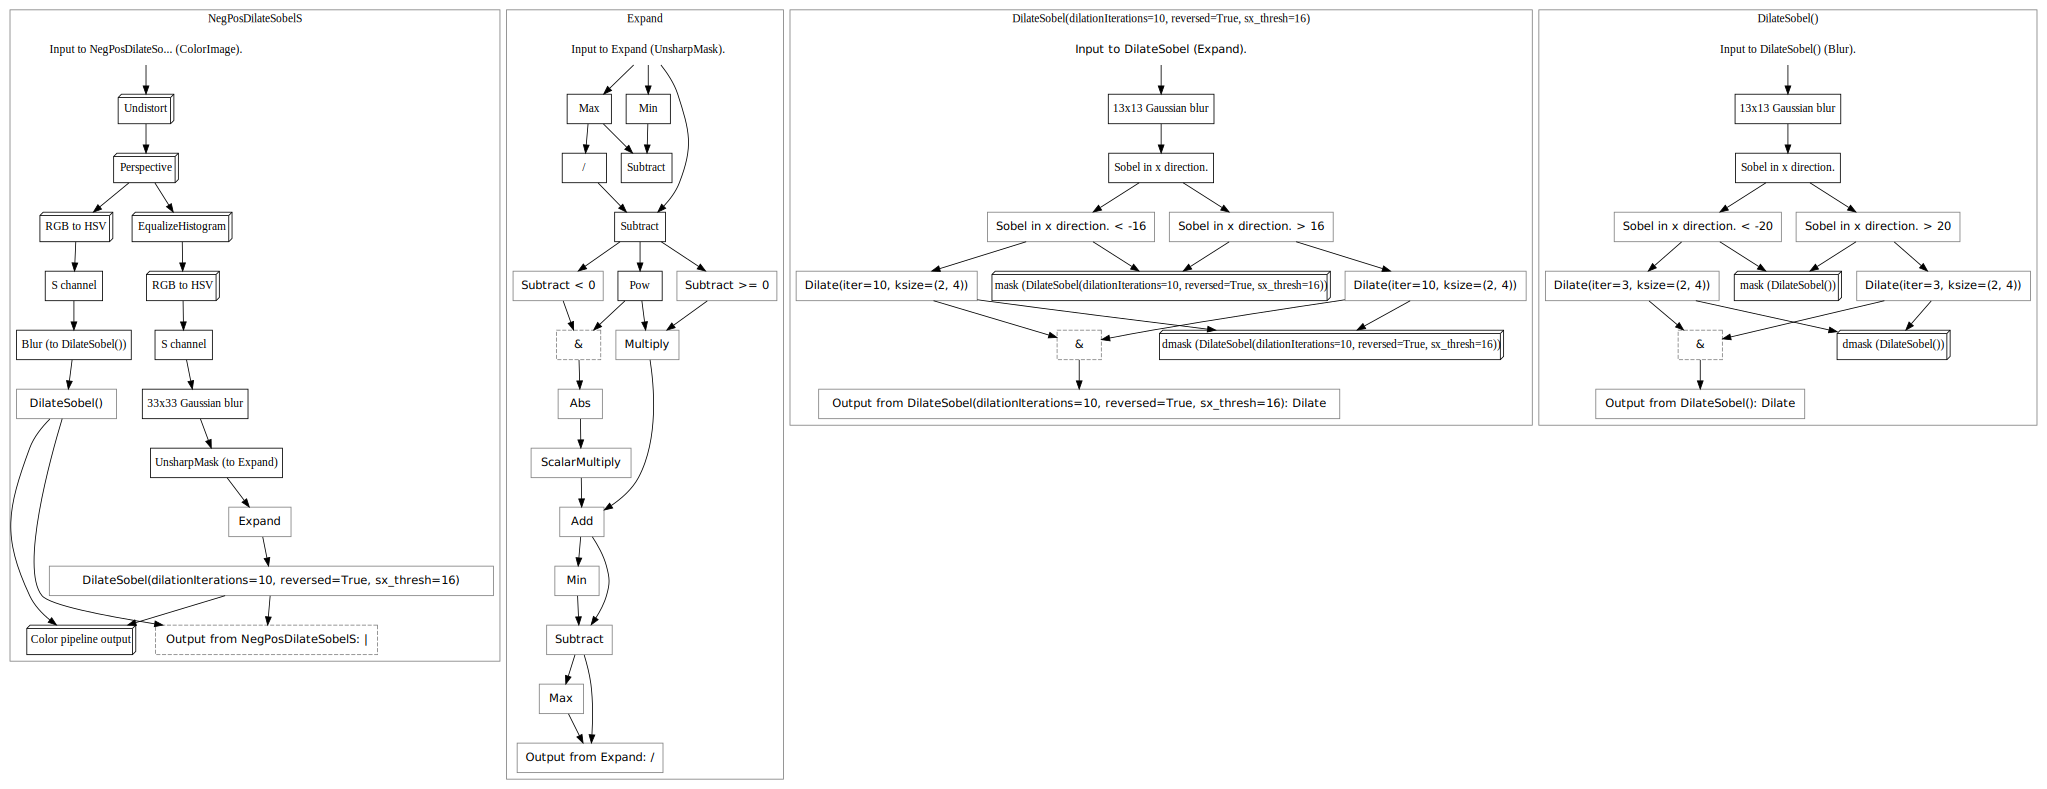

In [41]:
frame = allFrames['harder_challenge'][-12]
negPosDilateSobelS(frame)
negPosDilateSobelS.assembleGraph()
negPosDilateSobelS.draw(addKey=False, savePath='/tmp/%s' % negPosDilateSobelS, format='png')

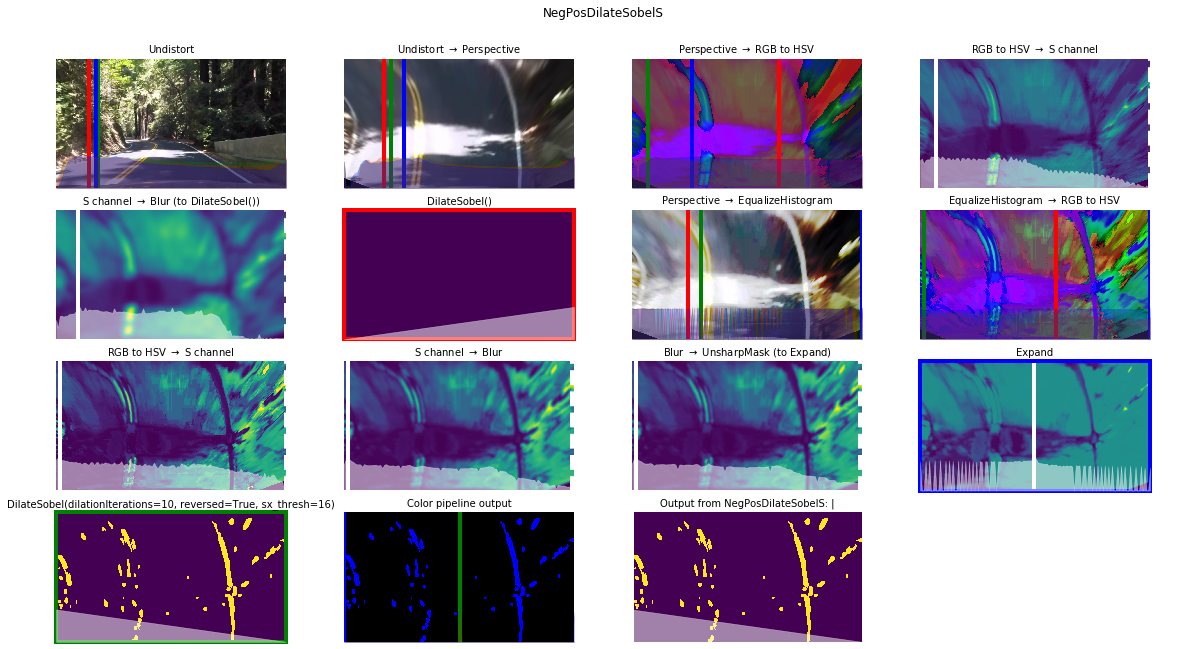

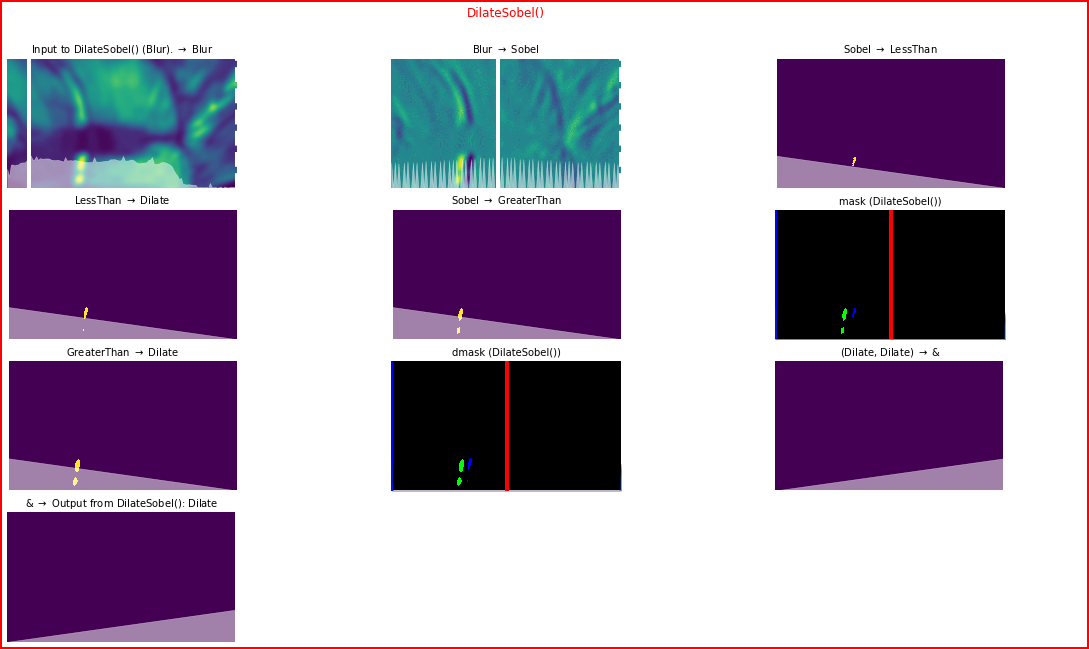

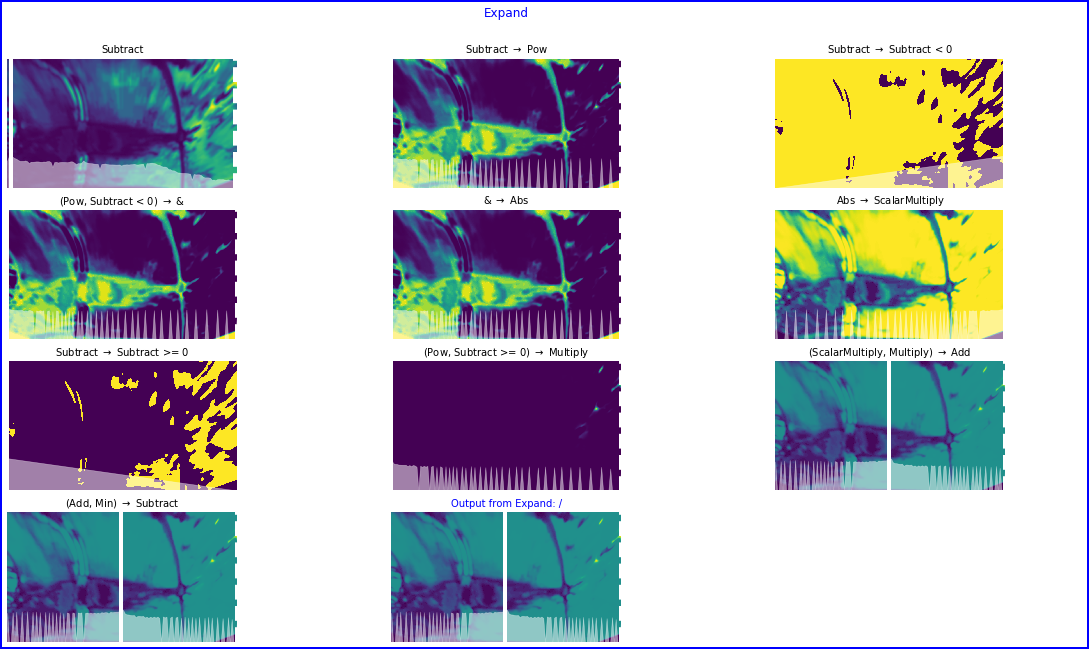

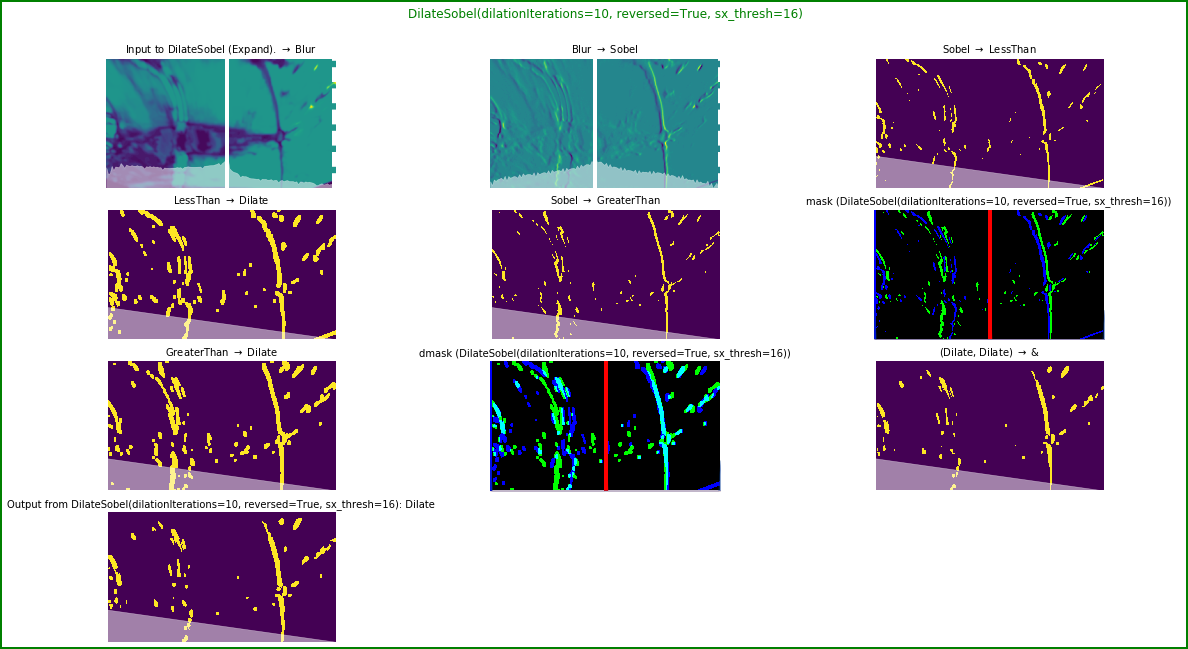

In [42]:
negPosDilateSobelS.showMembers(
    subplotKwargs=dict(figsize=(16,9)), 
    wspace=0, showMultistepParents=True,
    histogramOverlayAlpha=.5,
)

(<matplotlib.figure.Figure at 0x7f50c800e898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50c800d908>)

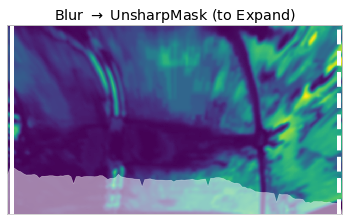

In [43]:
expand = negPosDilateSobelS.getByKind(Expand, index=0)

parent = expand.parent()
parent.showValue(histogramOverlayAlpha=.5)

(<matplotlib.figure.Figure at 0x7f50c9c94f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50c7fd1860>)

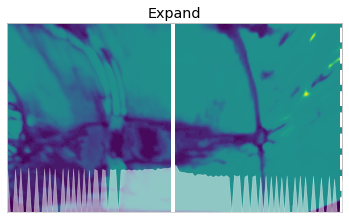

In [44]:
expand.showValue(histogramOverlayAlpha=.5)

(0, 10000)

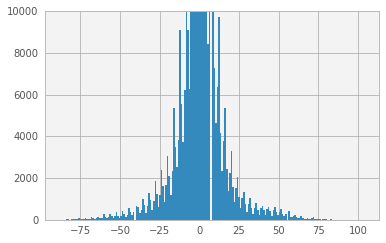

In [46]:
sobel = expand.input.getByKind(Sobel, which='descendants', index=0)

fig, ax = plt.subplots()
ax.hist(sobel.value.ravel(), bins=196);
ax.set_ylim(0, 10000)
# ax.set_yscale('log')

(<matplotlib.figure.Figure at 0x7f50c7c2ecc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50c7bb2278>)

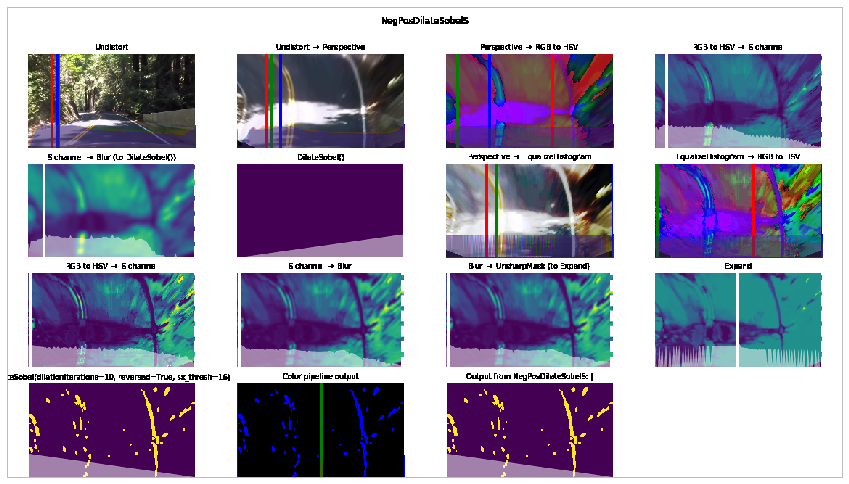

In [47]:
visualizeFilter = VisualizeFilter(negPosDilateSobelS)
fig, ax = plt.subplots(figsize=(16, 9))
show(visualizeFilter(frame, clearAxes=True, closeFigure=True, histogramOverlayAlpha=.5), ax=ax)

HBox(children=(IntProgress(value=0, description='cf-NegPosDilateSobelS-harder_challenge-vis-32frames.mp4: ', max=32), HTML(value='')))

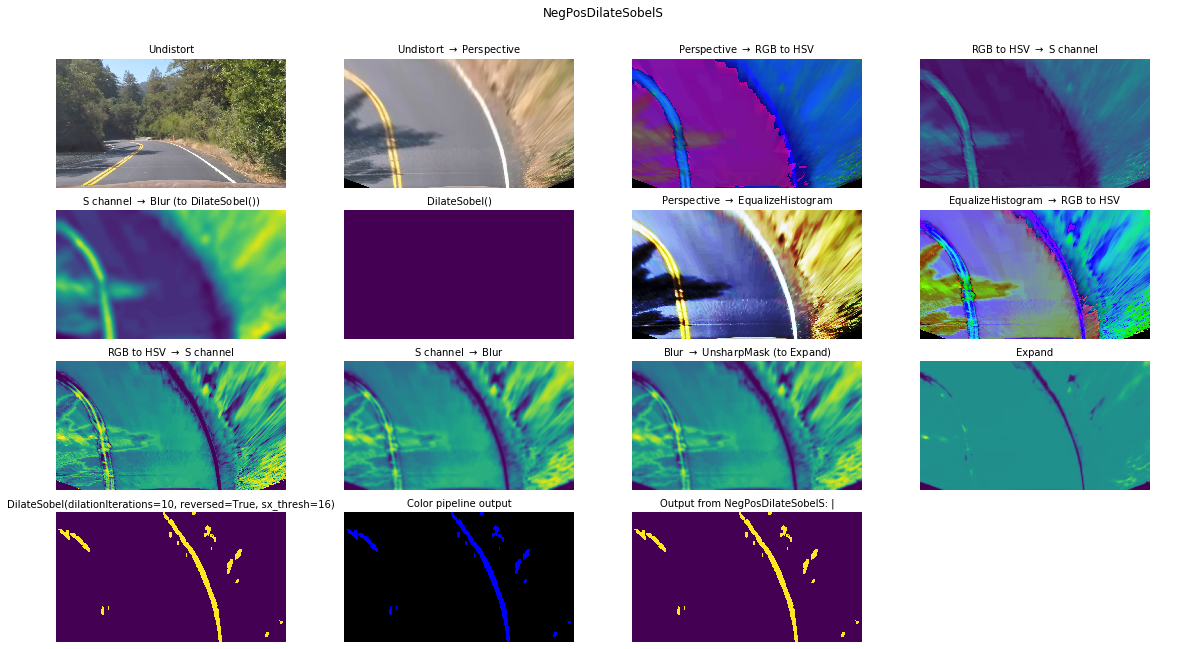

In [48]:
visualizeFilter = VisualizeFilter(negPosDilateSobelS)
vid, fig = visualizeFilter.visualizeFromKey('harder_challenge', maxFrames=32, histogramOverlayAlpha=.5);

In [49]:
vid